In [1]:
import os
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, LayerNormalization, MultiHeadAttention
from keras.optimizers import SGD

2024-04-07 11:36:19.688352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 11:36:20.683493: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/.local/lib/python3.10/site-packages/nvidia/cudnn/lib/:/usr/local/lib:/usr/local/cuda-12.1/lib64
2024-04-07 11:36:20.683571: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/.local/lib/p

In [2]:
import tensorflow as tf

# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("CUDA and GPU support is available.")
else:
    print("CUDA and GPU support is not available.")

CUDA and GPU support is available.


2024-04-07 11:36:24.181659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-07 11:36:24.243331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-07 11:36:24.243542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
PATH = "/home/user/repos/DL1"
PATH_TRAIN  = PATH + "/DATASET/train"
PATH_TEST   = PATH + "/DATASET/test"
PATH_VALID  = PATH + "/DATASET/valid"
PATH_MODELS = PATH + "/MODELS/"

In [13]:
IMAGE_SIZE = (32, 32)
INPUT_SHAPE = (32, 32, 3)
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 5
SEED = 69
DEFAULT_OPTIMIZER = 'adam'
DEFAULT_LOSS = 'categorical_crossentropy'

In [143]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=10,  # Rotate images by up to 20 degrees
    width_shift_range=0.1,  # Shift width by up to 20% of total width
    height_shift_range=0.1,  # Shift height by up to 20% of total height
    shear_range=0.1,  # Apply shear transformation by up to 20 degrees
    zoom_range=0.1,  # Zoom in by up to 20%
    horizontal_flip=True,  # Flip horizontally with a probability of 50%
    fill_mode='nearest'  # Use nearest fill mode for newly created pixels
)
test_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
)

train_generator = train_datagen.flow_from_directory(
    PATH_TRAIN,
    seed=SEED,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    PATH_TEST,
    seed=SEED,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)


Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


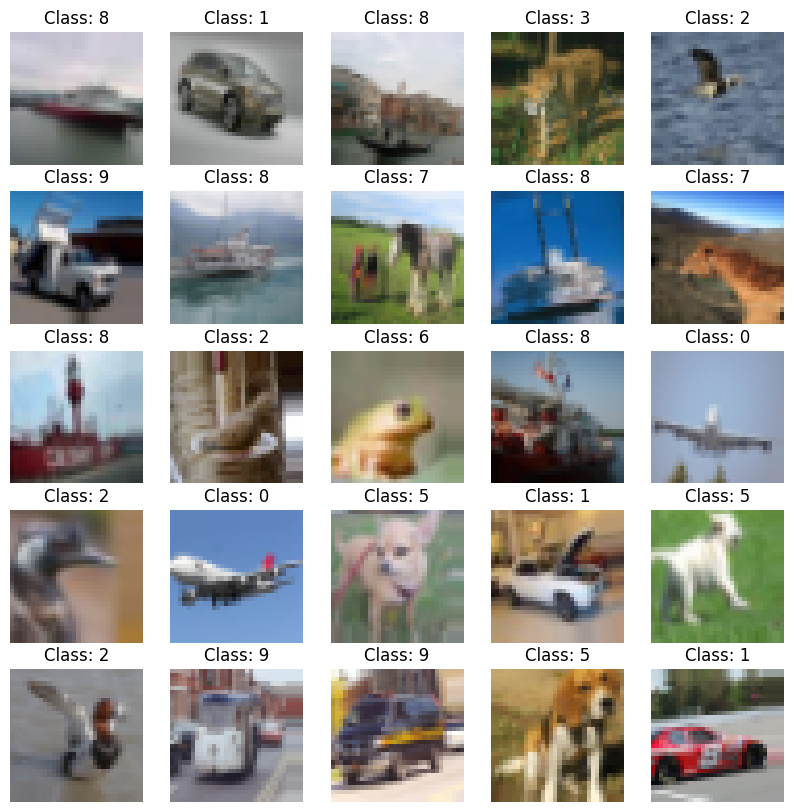

In [6]:
# Get a batch of images and labels from the generator
images, labels = next(train_generator)

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(min(len(images), 25)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])  # Ensure images are of type uint8
    plt.title(f"Class: {labels[i].argmax()}")  # Display the class label
    plt.axis("off")
plt.show()


In [7]:
class BaseModel(ABC):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.optimizer = optimizer
        self.loss = loss

        self.model = self.create_model()
        self.compile_model()

    @abstractmethod
    def create_model(self):
        pass

    def compile_model(self):
        self.model.compile(optimizer=self.optimizer,
                           loss=self.loss,
                           metrics=['accuracy'])

    def train(self, train_generator, epochs=EPOCHS):
        history = self.model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // BATCH_SIZE,
            epochs=epochs
        )
        return history

    def evaluate(self, test_generator):
        test_loss, test_accuracy = self.model.evaluate(test_generator)
        return test_accuracy



In [27]:
class CNN(BaseModel):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS):
        super().__init__(input_shape, num_classes, optimizer, loss)
    def create_model(self):
        return tf.keras.Sequential([
            tf.keras.layers.Input(shape=self.input_shape),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])

In [33]:
class CNN_with_dropout(BaseModel):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS, dropout_rate=0.3):
        self.dropout_rate = dropout_rate
        super().__init__(input_shape, num_classes, optimizer, loss)
    def create_model(self):
        return tf.keras.Sequential([
            tf.keras.layers.Input(shape=self.input_shape),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(self.dropout_rate),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(self.dropout_rate),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dropout(self.dropout_rate),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(self.dropout_rate),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])

In [140]:
class ResNet32(BaseModel):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS):
        super().__init__(input_shape, num_classes, optimizer, loss)

    def residual_block(self, x, filters, downsample=False):
        strides = 2 if downsample else 1

        identity = x

        x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)

        if downsample:
            identity = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(identity)
            identity = tf.keras.layers.BatchNormalization()(identity)

        x = tf.keras.layers.add([x, identity])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    def create_model(self):
        inputs = tf.keras.layers.Input(shape=self.input_shape)

        x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
        x = tf.keras.layers.BatchNormalization()(x)

        x = self.residual_block(x, 64)
        x = self.residual_block(x, 64)
        x = self.residual_block(x, 128, downsample=True)
        x = self.residual_block(x, 128)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        outputs = tf.keras.layers.Dense(self.num_classes, activation='softmax')(x)

        return tf.keras.Model(inputs, outputs)

In [125]:
class ResNeXt32(BaseModel):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS):
        super().__init__(input_shape, num_classes, optimizer, loss)


    def create_model(self):
        def residual_block(inputs, filters, cardinality=8, strides=(1, 1)):
            shortcut = inputs
            
            # Cardinality split
            splits = filters // cardinality
            groups = []
            for i in range(cardinality):
                group = tf.keras.layers.Conv2D(splits, kernel_size=(1, 1), strides=strides, padding='same')(inputs)
                groups.append(group)
            group_merge = tf.keras.layers.concatenate(groups, axis=-1)
            conv1 = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='same')(group_merge)
            conv1 = tf.keras.layers.BatchNormalization()(conv1)
            conv1 = tf.keras.layers.ReLU()(conv1)
            
            # Second conv layer
            conv2 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(conv1)
            conv2 = tf.keras.layers.BatchNormalization()(conv2)
            conv2 = tf.keras.layers.ReLU()(conv2)

            # Third conv layer
            conv3 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(1, 1), strides=(1, 1), padding='same')(conv2)
            conv3 = tf.keras.layers.BatchNormalization()(conv3)

            # Add the shortcut to the main path
            shortcut = tf.keras.layers.Conv2D(filters * 2, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
            shortcut = tf.keras.layers.BatchNormalization()(shortcut)

            output = tf.keras.layers.add([conv3, shortcut])
            output = tf.keras.layers.ReLU()(output)

            return output
        input_layer = tf.keras.layers.Input(shape=self.input_shape)
        # Initial convolutional layer
        x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

        # Residual blocks
        x = residual_block(x, filters=64)
        x = residual_block(x, filters=64)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = residual_block(x, filters=128)
        x = residual_block(x, filters=128)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        # Dense layers
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)

        # Output layer
        output_layer = tf.keras.layers.Dense(self.num_classes, activation='softmax')(x)

        model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

        return model

In [63]:
class VGG32(BaseModel):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS):
        super().__init__(input_shape, num_classes, optimizer, loss)

    def conv_block(self, x, filters, kernel_size):
        x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        return x

    def create_model(self):
        inputs = tf.keras.layers.Input(shape=self.input_shape)

        x = self.conv_block(inputs, 32, (3, 3))
        x = self.conv_block(x, 64, (3, 3))
        x = self.conv_block(x, 128, (3, 3))

        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        x = tf.keras.layers.Dense(self.num_classes, activation='softmax')(x)

        return tf.keras.Model(inputs, x)

In [99]:
class ViT(BaseModel):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS):
        super().__init__(input_shape, num_classes, optimizer, loss)

    def create_model(self):
        num_layers = 3  # Increased depth
        num_heads = 6  # Increased number of attention heads
        hidden_size = 64  # Increased hidden size

        inputs = tf.keras.Input(shape=self.input_shape)

        patch_size = (4, 4)
        num_patches = (self.input_shape[0] // patch_size[0]) * (self.input_shape[1] // patch_size[1])
        patch_embedding = tf.keras.layers.Conv2D(hidden_size, kernel_size=patch_size, strides=patch_size, padding="same")(inputs)
        patch_embedding = tf.keras.layers.Reshape((num_patches, hidden_size))(patch_embedding)

        positions = tf.range(num_patches)[:, tf.newaxis]
        positions = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=hidden_size)(positions)
        positions = tf.reshape(positions, [1, num_patches, hidden_size])  # Reshape to match patch_embedding shape
        positions = tf.tile(positions, [tf.shape(patch_embedding)[0], 1, 1])  # Repeat along batch dimension
        embeddings = patch_embedding + positions

        for _ in range(num_layers):
            attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_size)(embeddings, embeddings)
            embeddings = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + embeddings)
            ff_output = tf.keras.layers.Dense(hidden_size, activation='relu')(embeddings)  # Increased hidden size
            ff_output = tf.keras.layers.Dense(hidden_size)(ff_output)  # Increased hidden size
            ff_output = tf.keras.layers.Dropout(0.1)(ff_output)
            embeddings = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output + embeddings)

        cls_token = embeddings[:, 0, :]
        outputs = tf.keras.layers.Dense(self.num_classes, activation="softmax")(cls_token)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

In [18]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train'], loc='upper left')
    plt.show()

In [141]:
optimizer = 'nadam'


model = ResNet32(optimizer=optimizer)
model.model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_840 (Conv2D)            (None, 32, 32, 64)   1792        ['input_51[0][0]']               
                                                                                                  
 batch_normalization_162 (Batch  (None, 32, 32, 64)  256         ['conv2d_840[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_841 (Conv2D)            (None, 32, 32, 64)   36928       ['batch_normalization_162[

In [142]:
# Train the model
history = model.train(train_generator, epochs=EPOCHS)

# Evaluate the model on the test set
test_accuracy = model.evaluate(test_generator)

# Print test accuracy
print("Test Accuracy:", test_accuracy)

Epoch 1/5
703/703 [==============================] - 63s 79ms/step - loss: 1.4092 - accuracy: 0.4841
Epoch 2/5
703/703 [==============================] - 55s 79ms/step - loss: 1.1162 - accuracy: 0.5997
Epoch 3/5
703/703 [==============================] - 55s 78ms/step - loss: 0.9885 - accuracy: 0.6475
Epoch 4/5
703/703 [==============================] - 55s 78ms/step - loss: 0.9023 - accuracy: 0.6792
Epoch 5/5
704/704 [==============================] - 56s 80ms/step - loss: 1.0871 - accuracy: 0.6279
Test Accuracy: 0.6279333233833313


In [131]:
# model_name = 'ACC058_2-5MPARAMS_CNN_NODROP_AUG_NADAM_EPOCH5.tf'
# model_name = 'ACC056_2-5MPARAMS_CNN_DROP03_AUG_NADAM_EPOCH5.tf'
 model_name = 'ACC065_0-7MPARAMS_RES_NODROP_AUG_NADAM_EPOCH5.tf'
# model_name = 'ACC065_2-7MPARAMS_RES_NODROP_AUG_NADAM_EPOCH5.tf'
# model_name = 'ACC064_1-3MPARAMS_VGG_NODROP_AUG_NADAM_EPOCH5.tf'
# model_name = 'ACC047_0-4MPARAMS_VIT_DROP01_AUG_NADAM_EPOCH5.tf'
# model_name = 'ACC057_1-2MPARAMS_REX_NODROP_AUG_NADAM_EPOCH5.tf'

if os.path.exists(PATH_MODELS + model_name):
    print(f"Warning: Model file already exists.")
else:
    model.model.save(PATH_MODELS + model_name)
    print("Model saved successfully.")

INFO:tensorflow:Assets written to: /home/user/repos/DL1/MODELS/ACC065_2-7MPARAMS_RES_NODROP_AUG_NADAM_EPOCH5.tf/assets


INFO:tensorflow:Assets written to: /home/user/repos/DL1/MODELS/ACC065_2-7MPARAMS_RES_NODROP_AUG_NADAM_EPOCH5.tf/assets


Model saved successfully.
